# importing libraries

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from matplotlib import pyplot as plt
from google.colab import files
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# importing data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/MyDrive/NN_HW2_Face_Emotion/TRAIN')
os.chdir('/content/drive/MyDrive/NN_HW2_Face_Emotion/TUNE')

In [ ]:
train='/content/drive/MyDrive/NN_HW2_Face_Emotion/TRAIN'
tune='/content/drive/MyDrive/NN_HW2_Face_Emotion/TUNE'


# preprocessing data

In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Function to load and augment images
def load_and_augment_images(folder_path):
    images = []
    labels = []

    # Map emotion labels to numeric values
    emotion_mapping = {
        'happy': 0,
        'anger': 1,
        'contempt': 2,
        'disgust': 3,
        'fear': 4,
        'neutral': 5,
        'sad': 6,
        'surprise': 7
    }

    # ImageDataGenerator for augmentations
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )

    for emotion_folder in os.listdir(folder_path):
        emotion_label = emotion_mapping[emotion_folder]
        emotion_folder_path = os.path.join(folder_path, emotion_folder)

        for filename in os.listdir(emotion_folder_path):
            image_path = os.path.join(emotion_folder_path, filename)
            image = cv2.imread(image_path)

            # Normalize the image
            normalized_image = image / 255.0

            # Reshape the image to (1, height, width, channels) for augmentation
            reshaped_image = normalized_image.reshape((1,) + normalized_image.shape)

            # Apply augmentations
            # augmented_images = datagen.flow(reshaped_image, batch_size=1)
            augmented_images = reshaped_image

            for i in range(1):  # Augment each image 1 time
                augmented_image = augmented_images[0]
                images.append(augmented_image)
                labels.append(emotion_label)

    return np.array(images), np.array(labels)


# Load and augment images
augmented_train_images, augmented_train_labels = load_and_augment_images(train)


# shuffling data

In [ ]:

# Assuming you have loaded your images and labels into the variables `augmented_images` and `augmented_labels`

# Combine images and labels
combined_data = list(zip(augmented_train_images, augmented_train_labels))

# Define the percentage to shuffle (e.g., 3%)
shuffle_percentage = 2

# Shuffle a percentage of data within each class
shuffled_data = []

# Number of classes
num_classes = len(np.unique(augmented_train_labels))

for i in range(num_classes):
    # Extract data for the current class
    class_data = [(img, label) for img, label in combined_data if label == i]

    # Determine the number of samples to shuffle (5% of the class data)
    num_samples_to_shuffle = int(len(class_data) * (shuffle_percentage / 100))

    # Randomly select the samples to shuffle
    samples_to_shuffle = np.random.choice(len(class_data), num_samples_to_shuffle, replace=False)

    # Shuffle the order of the selected samples
    class_data_shuffled = [class_data[idx] for idx in samples_to_shuffle]
    np.random.shuffle(class_data_shuffled)

    # Append the shuffled data to the final list
    shuffled_data.extend(class_data_shuffled)

# Unpack the shuffled data
shuffled_images, shuffled_labels = zip(*shuffled_data)

# Convert to numpy arrays
shuffled_images = np.array(shuffled_images)
shuffled_labels = np.array(shuffled_labels)

augmented_train_images = shuffled_images
augmented_train_labels = shuffled_labels

# splitting test and train data

In [ ]:
# Assuming you have loaded your images and labels into the variables `augmented_images` and `augmented_labels`

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(augmented_train_images, augmented_train_labels, test_size=0.2, random_state=45)

# building AlexNet model

In [ ]:
# Build the AlexNet model
model = models.Sequential()

# Layer 1: Convolutional + Batch Normalization + ReLU + MaxPooling
model.add(layers.Conv2D(16, (9, 9), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Layer 2: Convolutional + Batch Normalization + ReLU + MaxPooling
model.add(layers.Conv2D(32, (7, 7), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Layer 3: Convolutional + Batch Normalization + ReLU + MaxPooling
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Layer 4: Convolutional + Batch Normalization + ReLU + MaxPooling
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Layer 5: Convolutional + Batch Normalization + ReLU + MaxPooling
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))

# Compile the model with specified hyperparameters
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 16)      3904      
                                                                 
 batch_normalization (Batch  (None, 120, 120, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 54, 54, 32)        25120     
                                                                 
 batch_normalization_1 (Bat  (None, 54, 54, 32)        128       
 chNormalization)                                                
                                                        

# training AlexNet

In [ ]:

# Train the model with specified batch size and epochs
history = model.fit(augmented_train_images, augmented_train_labels, epochs=24, batch_size=400, validation_split=0.25)



Epoch 1/24
1/1 [==============================] - 0s 161ms/step - loss: 0.0575 - accuracy: 0.9833 - val_loss: 1.3110 - val_accuracy: 0.7500
Epoch 2/24
1/1 [==============================] - 0s 106ms/step - loss: 0.0131 - accuracy: 1.0000 - val_loss: 1.3422 - val_accuracy: 0.7500
Epoch 3/24
1/1 [==============================] - 0s 113ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.3777 - val_accuracy: 0.7500
Epoch 4/24
1/1 [==============================] - 0s 105ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.4159 - val_accuracy: 0.7250
Epoch 5/24
1/1 [==============================] - 0s 108ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.4475 - val_accuracy: 0.7250
Epoch 6/24
1/1 [==============================] - 0s 95ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.4752 - val_accuracy: 0.7500
Epoch 7/24
1/1 [==============================] - 0s 107ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.5049 - val_accuracy: 0.7250
Epoch 8/24
1/1 [=====

# fine tuning the model

In [ ]:

# Function to load and normalize images
def load_and_normalize_images(folder_path):
    images = []
    labels = []

    # Map emotion labels to numeric values
    emotion_mapping = {
        'happy': 0,
        'anger': 1,
        'contempt': 2,
        'disgust': 3,
        'fear': 4,
        'neutral': 5,
        'sad': 6,
        'surprise': 7
    }

    for emotion_folder in os.listdir(folder_path):
        emotion_label = emotion_mapping[emotion_folder]
        emotion_folder_path = os.path.join(folder_path, emotion_folder)

        for filename in os.listdir(emotion_folder_path):
            image_path = os.path.join(emotion_folder_path, filename)
            image = cv2.imread(image_path)

            # Normalize the image (you may need to adjust this based on your requirements)
            normalized_image = image / 255.0

            images.append(normalized_image)
            labels.append(emotion_label)

    return np.array(images), np.array(labels)


# Load and normalize images
tune_images, tune_labels = load_and_normalize_images(tune)


In [ ]:
# Assuming you have loaded your 'tune' set into the variables `tune_images` and `tune_labels`

# Fine-tune the model on the 'tune' set
history = model.fit(tune_images, tune_labels, epochs=13, batch_size=400, validation_split=0.2)


Epoch 1/13
4/4 [==============================] - 1s 231ms/step - loss: 0.0048 - accuracy: 0.9992 - val_loss: 8.8390 - val_accuracy: 0.0406
Epoch 2/13
4/4 [==============================] - 1s 177ms/step - loss: 0.0030 - accuracy: 0.9992 - val_loss: 8.8324 - val_accuracy: 0.0437
Epoch 3/13
4/4 [==============================] - 1s 158ms/step - loss: 0.0031 - accuracy: 0.9984 - val_loss: 8.7655 - val_accuracy: 0.0437
Epoch 4/13
4/4 [==============================] - 1s 158ms/step - loss: 0.0023 - accuracy: 0.9992 - val_loss: 8.5221 - val_accuracy: 0.0437
Epoch 5/13
4/4 [==============================] - 1s 181ms/step - loss: 0.0028 - accuracy: 0.9984 - val_loss: 8.3467 - val_accuracy: 0.0406
Epoch 6/13
4/4 [==============================] - 1s 208ms/step - loss: 0.0041 - accuracy: 0.9992 - val_loss: 8.2824 - val_accuracy: 0.0469
Epoch 7/13
4/4 [==============================] - 1s 216ms/step - loss: 0.0050 - accuracy: 0.9992 - val_loss: 8.2486 - val_accuracy: 0.0437
Epoch 8/13
4/4 [====

# accuracy and loss plotting

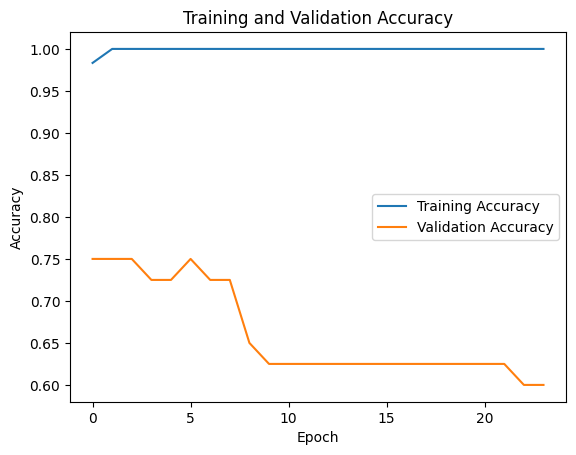

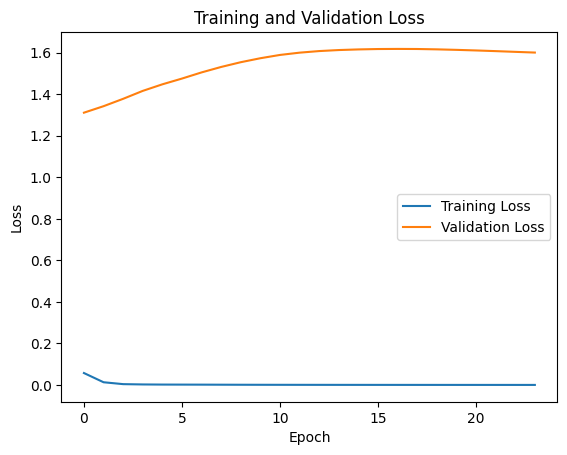

In [ ]:

# Train the model and store the training history
# history = model.fit(X_train, y_train, epochs=24, batch_size=400, validation_data=(X_test, y_test))

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## confusion matrix

In [ ]:
def draw_confusion_matrix(matrix):
    green = (30, 200, 40, 160)
    red = (255, 25, 0, 140)

    x = matrix.shape[1]
    y = matrix.shape[0]

    colors = [[green if i==j else red for i in range(x)] for j in range(y)]
    colors = np.array(colors).astype(np.uint8)

    fig, ax = plt.subplots(figsize=(4, 4), dpi=90)
    ax.imshow(colors)

    ax.set_xticks(np.arange(x), labels=range(x))
    ax.set_yticks(np.arange(y), labels=range(y))

    ax.set_xticks(np.arange(-.5, x, 1), minor=True)
    ax.set_yticks(np.arange(-.5, y, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
    ax.tick_params(which='minor', bottom=False, left=False)

    ax.set_xlabel("prediction")
    ax.set_ylabel("label")

    for i in range(y):
        for j in range(x):
            text = ax.text(j, i, matrix[i][j], ha="center", va="center", color='black')

    ax.set_title("Confusion Matrix")
    fig.tight_layout()
    plt.show()

1/1 [==============================] - 0s 26ms/step


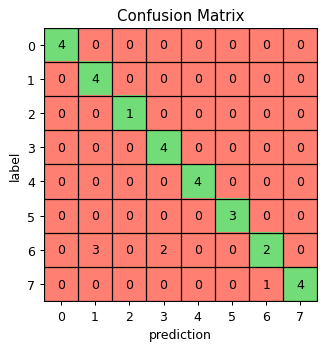

In [ ]:
# Obtain predicted probabilities for the test set
probas = model.predict(X_test)
y_pred = np.argmax(probas, axis=-1)
y_pred_val = np.max(probas, axis=-1)
y_test_ = to_categorical(y_test, num_classes=8)

draw_confusion_matrix(
    confusion_matrix(y_test, y_pred)
)

# computing F1, precision, and recall

In [ ]:

# Convert probabilities to binary predictions using a threshold of 0.5
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.57      1.00      0.73         4
           2       1.00      1.00      1.00         1
           3       0.67      1.00      0.80         4
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         3
           6       0.67      0.29      0.40         7
           7       1.00      0.80      0.89         5

    accuracy                           0.81        32
   macro avg       0.86      0.89      0.85        32
weighted avg       0.83      0.81      0.79        32



# ROC plot

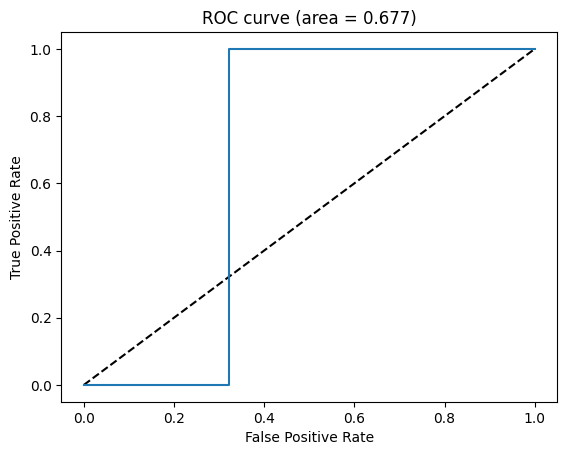

In [ ]:
# Calculate the False Positive Rate (FPR), True Positive Rate (TPR), and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_val, pos_label=2)

# Calculate the Area Under the Curve (AUC)
area_under_curve = auc(fpr, tpr)

# Plot the ROC curve
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random chance
plt.plot(fpr, tpr)  # Plot the actual ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (area = {:.3f})'.format(area_under_curve))
plt.show()